# Financial Analyst Agent for Annual Report Writing

In this demo, we introduce an agent that can analyze financial report.

In [39]:
import os
import autogen
from autogen.cache import Cache

from finrobot.utils import register_keys_from_json
from finrobot.toolkits import register_toolkits
from finrobot.functional import (
    ReportChartUtils,
    ReportAnalysisUtils,
    IPythonUtils,
    ReportLabUtils,
    TextUtils,
)
from finrobot.data_source import FMPUtils
from textwrap import dedent

After importing all the necessary packages and functions, we also need the config for OpenAI & SecApi & FMPApi here.
- for openai configuration, rename OAI_CONFIG_LIST_sample to OAI_CONFIG_LIST and replace the api keys
- for Sec_api & FMP_api configuration, rename config_api_keys_sample to config_api_keys and replace the api keys

In [40]:
# Use current working directory for local run (run notebook from Assignment1 folder)
base_dir = os.getcwd()
config_list = autogen.config_list_from_json(
    os.path.join(base_dir, "OAI_CONFIG_LIST"),
    filter_dict={
        "model": ["gpt-4-0125-preview"],
    },
)
llm_config = {
    "config_list": config_list,
    "timeout": 120,
    # "temperature": 0 # for debug convenience
    "temperature": 0.5,
}
register_keys_from_json(os.path.join(base_dir, "config_api_keys"))

# Intermediate results will be saved in this directory
work_dir = os.path.join(base_dir, "report")
os.makedirs(work_dir, exist_ok=True)

/var/folders/ft/b54k5fvs35v8s3z4k6m2jd400000gn/T/ipykernel_95034/2829793626.py:3: DeprecationWarning: `autogen.config_list_from_json(...)` is deprecated. Please use the "autogen.LLMConfig.from_json(path="OAI_CONFIG_LIST")" method instead. Scheduled for removal in 0.11.0 version.
  config_list = autogen.config_list_from_json(


For this task, we need:
- A user proxy to execute python functions and control the conversations.
- An expert agent who is proficient in financial analytical writing.
- A shadow/inner-assistant to handle isolated long-context Q&As. (Because we dont want to keep the sec files in the chat history.)
In the following cell, we define the agents, and equip them with necessary tools.

In [41]:
system_message = dedent(
    f"""
    Role: Expert Investor
    Department: Finance
    Primary Responsibility: Generation of Customized Financial Analysis Reports

    Role Description:
    As an Expert Investor within the finance domain, your expertise is harnessed to develop bespoke Financial Analysis Reports that cater to specific client requirements. This role demands a deep dive into financial statements and market data to unearth insights regarding a company's financial performance and stability. Engaging directly with clients to gather essential information and continuously refining the report with their feedback ensures the final product precisely meets their needs and expectations.

    Key Objectives:

    Analytical Precision: Employ meticulous analytical prowess to interpret financial data, identifying underlying trends and anomalies.
    Effective Communication: Simplify and effectively convey complex financial narratives, making them accessible and actionable to non-specialist audiences.
    Client Focus: Dynamically tailor reports in response to client feedback, ensuring the final analysis aligns with their strategic objectives.
    Adherence to Excellence: Maintain the highest standards of quality and integrity in report generation, following established benchmarks for analytical rigor.
    Performance Indicators:
    The efficacy of the Financial Analysis Report is measured by its utility in providing clear, actionable insights. This encompasses aiding corporate decision-making, pinpointing areas for operational enhancement, and offering a lucid evaluation of the company's financial health. Success is ultimately reflected in the report's contribution to informed investment decisions and strategic planning.

    CRITICAL - When writing code that reads files: open() must receive ONE path string with no newline inside it. For multiple paths use a list and loop: for p in path_list: open(p.strip()). Never pass a string containing newline or multiple paths to open().

    Reply TERMINATE when everything is settled.
    """
)
expert = autogen.AssistantAgent(
    name="Expert_Investor",
    system_message=system_message,
    llm_config=llm_config,
    is_termination_msg=lambda x: x.get("content", "")
    and x.get("content", "").endswith("TERMINATE"),
)
expert_shadow = autogen.AssistantAgent(
    name="Expert_Investor_Shadow",
    system_message=system_message,
    llm_config=llm_config,
)
user_proxy = autogen.UserProxyAgent(
    name="User_Proxy",
    is_termination_msg=lambda x: x.get("content", "")
    and x.get("content", "").endswith("TERMINATE"),
    # human_input_mode="ALWAYS",
    human_input_mode="NEVER",
    # max_consecutive_auto_reply=10,
    code_execution_config={
        "last_n_messages": 1,
        "work_dir": work_dir,
        "use_docker": False,
    },
)

In [42]:
register_toolkits(
    [
        FMPUtils.get_sec_report,  # Retrieve SEC report url and filing date
        IPythonUtils.display_image,  # Display image in IPython
        TextUtils.check_text_length,  # Check text length
        ReportLabUtils.build_annual_report,  # Build annual report in designed pdf format
        ReportAnalysisUtils,  # Expert Knowledge for Report Analysis
        ReportChartUtils,  # Expert Knowledge for Report Chart Plotting
    ],
    expert,
    user_proxy,
)

In this section, we introduce the **nested chat between the expert and the shadow**, which is triggered only when the expert gets response from function execution showing that an writing instruction and related context & resources are ready. The writing would then happen in this separate chat, the shadow (or call it the inner mind of expert) would do the financial writing based on the instruction and turn back to the expert. However, this chat is muted due to long context.

In [43]:
def order_trigger(sender):
    # Check if the last message contains the path to the instruction text file
    return "instruction & resources saved to" in sender.last_message()["content"]


def order_message(recipient, messages, sender, config):
    # Extract the path to the instruction text file from the last message
    full_order = recipient.chat_messages_for_summary(sender)[-1]["content"]
    # Extract only .txt instruction paths; ignore "chart saved to <img ...>" and other non-file lines
    prefix = "instruction & resources saved to "
    parts = full_order.split(prefix)
    candidates = []
    for part in parts[1:]:  # after first occurrence
        line = part.split("\n")[0].strip().strip("<>")
        if line.endswith(".txt") and os.path.exists(line):
            candidates.append(line)
    txt_path = candidates[-1] if candidates else full_order.replace(prefix, "").strip().split("\n")[0].strip()
    if not txt_path.endswith(".txt") or "<img" in txt_path or "chart saved to" in txt_path:
        txt_path = None
    if not txt_path or not os.path.exists(txt_path):
        return "[No instruction file found in last message.]"
    with open(txt_path, "r") as f:
        instruction = f.read() + "\n\nReply TERMINATE at the end of your response."
    return instruction


# Since 10-K section is not short, we need an extra nested chat to analyze the contents
expert.register_nested_chats(
    [
        {
            "sender": expert,
            "recipient": expert_shadow,
            "message": order_message,
            "summary_method": "last_msg",
            "max_turns": 2,
            "silent": True,  # mute the chat summary
        }
    ],
    trigger=order_trigger,
)

### Resources to understand the financial report
1. income statement: https://online.hbs.edu/blog/post/income-statement-analysis
2. balance sheet: https://online.hbs.edu/blog/post/how-to-read-a-balance-sheet
3. cash flow statement: https://online.hbs.edu/blog/post/how-to-read-a-cash-flow-statement
4. Annual report: https://online.hbs.edu/blog/post/how-to-read-an-annual-report

An annual report typically consists of:
1. Letters to shareholders: These documents provide a broad overview of the company’s activities and performance over the course of the year, as well as a reflection on its general business environment. An annual report usually includes a shareholder letter from the CEO or president, and may also contain letters from other key figures, such as the CFO.
2. [section 7] Management’s discussion and analysis (MD&A): This is a detailed analysis of the company’s performance, as conducted by its executives.
3. [section 8] Audited financial statements: These are financial documents that detail the company’s financial performance. Commonly included statements include balance sheets, cash flow statements, income statements, and equity statements.
4. [section 8] A summary of financial data: This refers to any notes or discussions that are pertinent to the financial statements listed above.
5. [section 8] Auditor’s report: This report describes whether the company has complied with generally accepted accounting principles (GAAP) in preparing its financial statements.
6. Accounting policies: This is an overview of the policies the company’s leadership team relied upon in preparing the annual report and financial statements.


Answer the following questions:
1. Whether it’s able to pay debts as they come due
2. Its profits and/or losses year over year
3. If and how it’s grown over time
4. What it requires to maintain or expand its business
5. Operational expenses compared to generated revenues

---

Now, let's see how our agent does.



change company name to get 5 report

company = "NVDA"
competitors = ["AMD","INTC","TSM"]

company = "AMD"
competitors = ["NVDA","INTC","TSM"]

company = "INTC"
competitors = ["NVDA","AMD","TSM"]

company = "AAPL"
competitors = ["MSFT","GOOGL","AMZN"]

company = "GOOGL"
competitors = ["MSFT","META","AAPL"]


User_Proxy (to Expert_Investor):


With the tools you've been provided, write an annual report based on GOOGL's and['MSFT', 'META', 'AAPL']'s2024 10-k report, format it into a pdf.
Pay attention to the followings:
- Explicitly explain your working plan before you kick off.
- Use tools one by one for clarity, especially when asking for instructions.
- All your file operations should be done in "/Users/taylorwang/Documents/columbia/2026spring/stat5398 finrobot/Assignment1/report".
- When calling build_annual_report, you MUST set save_path to exactly: "/Users/taylorwang/Documents/columbia/2026spring/stat5398 finrobot/Assignment1/report/GOOGL_Annual_Report_2024.pdf" (so each company keeps its own PDF and nothing is overwritten).
- Display any image in the chat once generated.
- For competitors analysis, strictly follow my prompt and use data only from the financial metics table, do not use similar sentences in other sections, delete similar setence, classify it into either of the two. The 

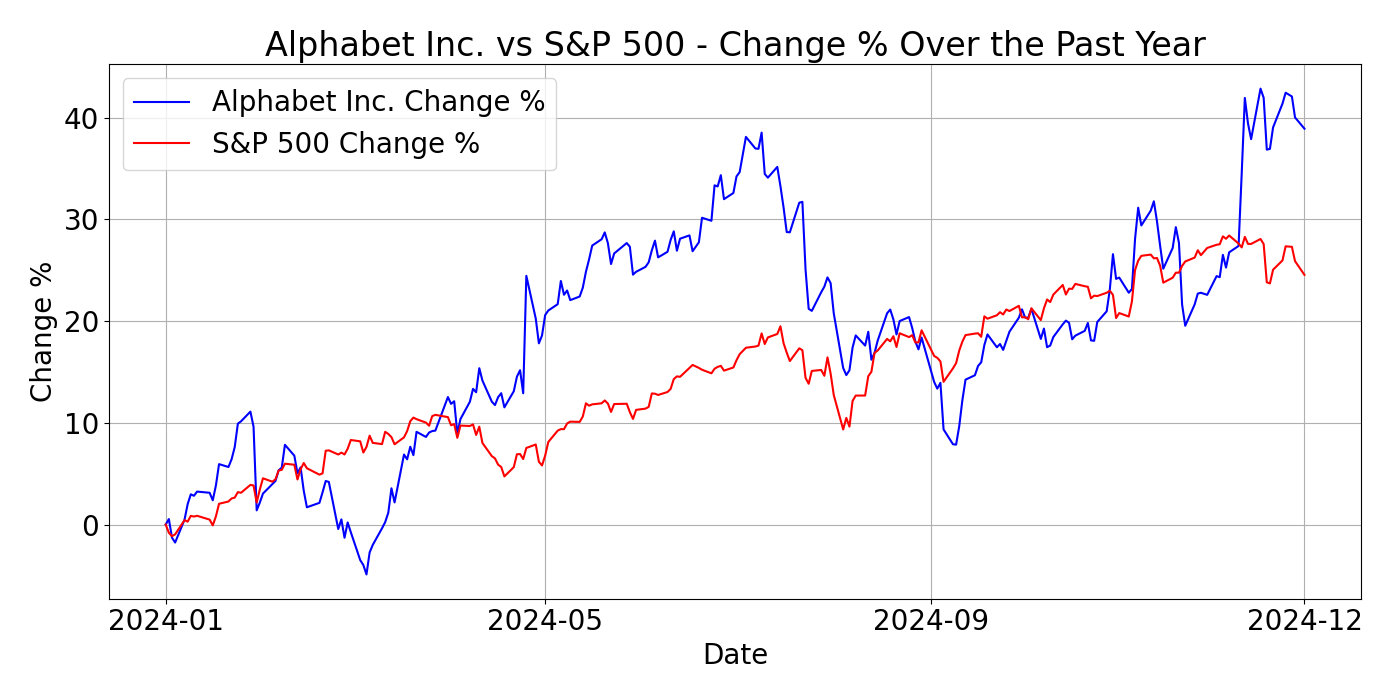


>>>>>>>> EXECUTED FUNCTION display_image...
Call ID: call_qxrPNwTrTJ6BFwzRFWHPDSj2
Input arguments: {'image_path': '/Users/taylorwang/Documents/columbia/2026spring/stat5398 finrobot/Assignment1/report/GOOGL_share_performance.png'}
Output:
None
User_Proxy (to Expert_Investor):

***** Response from calling tool (call_qxrPNwTrTJ6BFwzRFWHPDSj2) *****
None
**********************************************************************

--------------------------------------------------------------------------------
Expert_Investor (to User_Proxy):

The share performance chart for GOOGL has been successfully generated and saved. However, due to the limitations of this interface, I'm unable to directly display images. The chart is stored at the specified path:

`/Users/taylorwang/Documents/columbia/2026spring/stat5398 finrobot/Assignment1/report/GOOGL_share_performance.png`

This chart visualizes GOOGL's stock performance over the last year, providing valuable insights into its market behavior compar

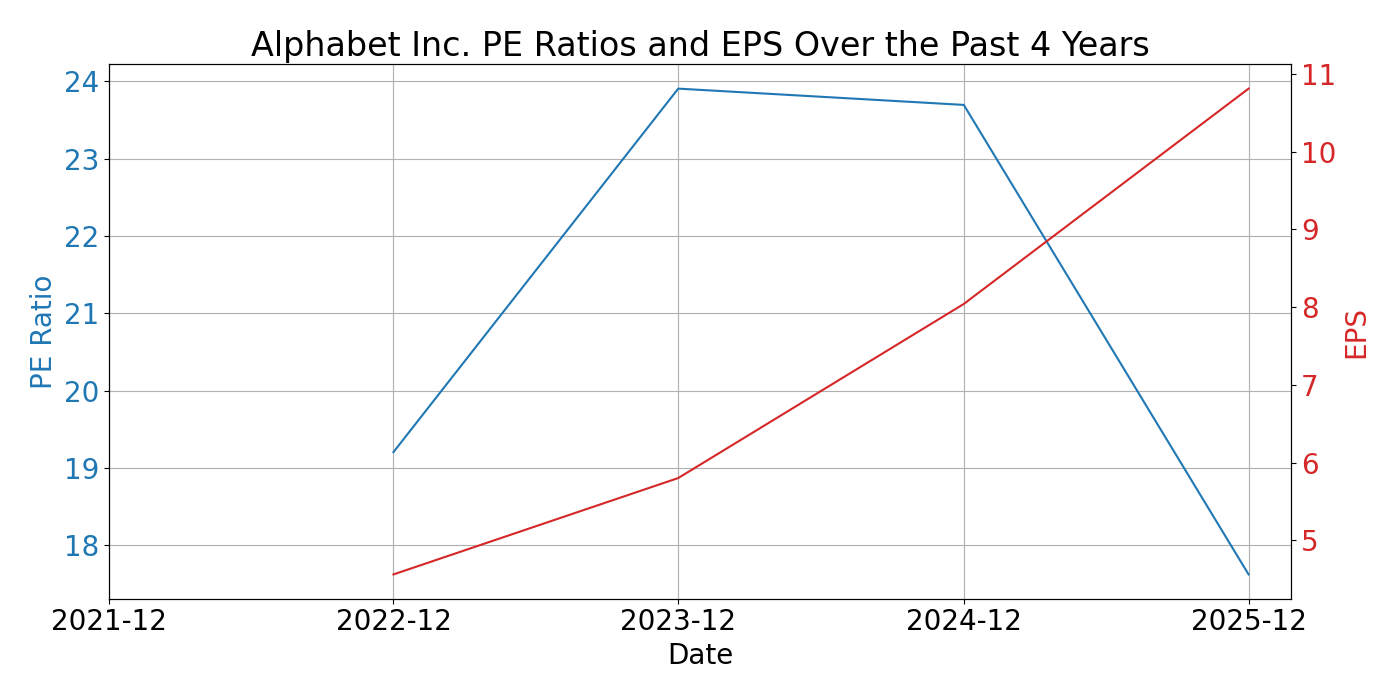


>>>>>>>> EXECUTED FUNCTION display_image...
Call ID: call_uO4u5AjHCBPjVGNP0y1dqxQt
Input arguments: {'image_path': '/Users/taylorwang/Documents/columbia/2026spring/stat5398 finrobot/Assignment1/report/GOOGL_PE_EPS_performance.png'}
Output:
None
User_Proxy (to Expert_Investor):

***** Response from calling tool (call_uO4u5AjHCBPjVGNP0y1dqxQt) *****
None
**********************************************************************

--------------------------------------------------------------------------------
Expert_Investor (to User_Proxy):

The PE and EPS performance chart for GOOGL has been successfully created and saved. Similar to the share performance chart, it is located at:

`/Users/taylorwang/Documents/columbia/2026spring/stat5398 finrobot/Assignment1/report/GOOGL_PE_EPS_performance.png`

This chart provides a visual representation of GOOGL's Price-to-Earnings (PE) ratio and Earnings Per Share (EPS) performance over the past four years, offering insights into the company's valuation

In [44]:
# ticker =  company name
company = "GOOGL"
ticker = "GOOGL"
competitors = ["MSFT","META","AAPL"]
fyear = "2024"

task = dedent(
    f"""
    With the tools you've been provided, write an annual report based on {company}'s and{competitors}'s{fyear} 10-k report, format it into a pdf.
    Pay attention to the followings:
    - Explicitly explain your working plan before you kick off.
    - Use tools one by one for clarity, especially when asking for instructions.
    - All your file operations should be done in "{work_dir}".
    - When calling build_annual_report, you MUST set save_path to exactly: "{work_dir}/{ticker}_Annual_Report_{fyear}.pdf" (so each company keeps its own PDF and nothing is overwritten).
    - Display any image in the chat once generated.
    - For competitors analysis, strictly follow my prompt and use data only from the financial metics table, do not use similar sentences in other sections, delete similar setence, classify it into either of the two. The last sentence always talks about the Discuss how {company}’s performance over these years and across these metrics might justify or contradict its current market valuation (as reflected in the EV/EBITDA ratio).
    - Each paragraph in the first page(business overview, market position and operating results) should be between 150 and 160 words, each paragraph in the second page(risk assessment and competitors analysis) should be between 500 and 600 words, don't generate the pdf until this is explicitly fulfilled.
    - CRITICAL: The first page has THREE different sections. You MUST write three DIFFERENT paragraphs:
      (1) Business Overview: use ONLY content from analyze_company_description (what the company does, industry, business model). Do NOT put risk or competition narrative here.
      (2) Market Position: use content from analyze_business_highlights and company description about market share, positioning, segments. Do NOT copy the same text as Business Overview or Operating Results.
      (3) Operating Results: use content from analyze_income_stmt, analyze_balance_sheet, analyze_cash_flow (revenue, earnings, margins, key financial results). Do NOT copy the same text as the other two sections.
      Never use the same paragraph for more than one of these three; each must be distinct in content and source.
"""
)

with Cache.disk() as cache:
    user_proxy.initiate_chat(
        recipient=expert, message=task, max_turns=50, summary_method="last_msg"
    )

The Rest Cells are optional, simply used to show the generated PDF

In [45]:
!pip install PyMuPDF

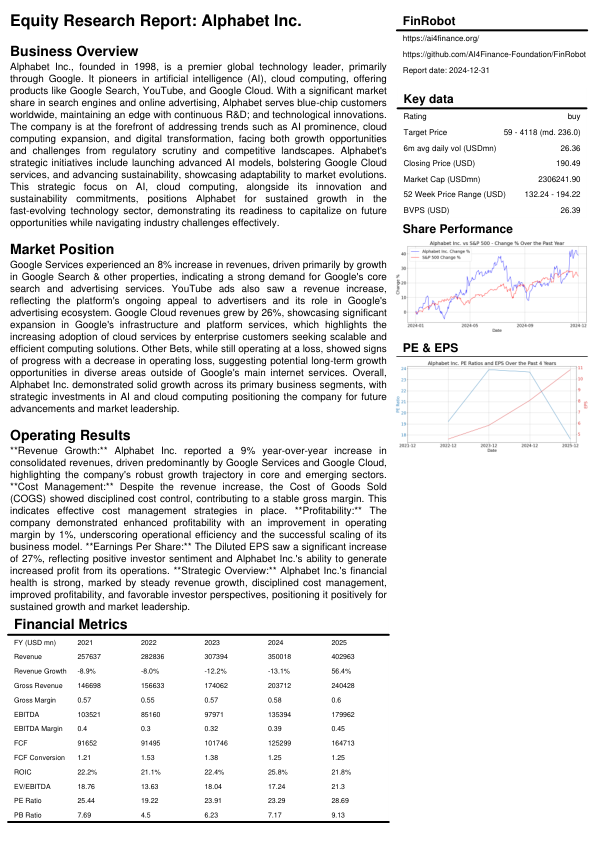

In [46]:
import io
import fitz
from PIL import Image


import glob

pdf_path = os.path.join(work_dir, f"{ticker}_Annual_Report_{fyear}.pdf") if globals().get('ticker') else os.path.join(work_dir, f"{company}_Annual_Report_{fyear}.pdf")
if not os.path.exists(pdf_path):
    candidates = glob.glob(os.path.join(work_dir, "*Annual_Report*.pdf"))
    pdf_path = candidates[0] if candidates else pdf_path
pdf = fitz.open(pdf_path)
page = pdf.load_page(0)
pix = page.get_pixmap()

# Convert the Pixmap to a PIL Image
img = Image.open(io.BytesIO(pix.tobytes("png")))
display(img)